In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

sns.set_style('whitegrid')

In [16]:
def display_result_season(y_true, y_pred):
    """
    Fonction fournie par l'utilisateur pour la visualisation saisonnière.
    y_true : Pandas Series avec DatetimeIndex
    y_pred : Array numpy ou Pandas Series (valeurs prédites)
    """
    dmap = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    cmap = {"DJF": "tab:blue", "MAM": "tab:green",
            "JJA": "tab:red", "SON": "tab:orange"}
    
    # Vérification et mappage des saisons
    seasons = y_true.index.month.map(dmap)
    colors = seasons.map(cmap)

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1 : Séries Temporelles
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")
    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2 : Scatter Plot (Actual vs Predicted)
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, c=colors, s=10)

    # Diagonale idéale (y=x)
    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_xlim(lb, ub)
    ax2.set_ylim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    # Légende des saisons
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=s, 
                   markerfacecolor=cmap[s], markersize=6)
        for s in ["DJF", "MAM", "JJA", "SON"]
    ]
    ax2.legend(handles=handles, title="Season")

    plt.show()

In [17]:
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=["Date"])
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=["Date"])
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=["Date"])

cf = cf[["FR"]]
ta = ta.loc[:, ta.columns.str.startswith("FR")]
tp = tp.loc[:, tp.columns.str.startswith("FR")]

In [18]:
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=["Date"])
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=["Date"])
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=["Date"])

cf = cf[["FR"]]
ta = ta.loc[:, ta.columns.str.startswith("FR")]
tp = tp.loc[:, tp.columns.str.startswith("FR")]

In [19]:
data = pd.concat([ta.mean(axis=1).rename("TA"),
                  tp.mean(axis=1).rename("TP"),
                  cf["FR"].rename("CF")], axis=1)

In [20]:
# Features & Target
X = data.drop(columns="CF")
y = data["CF"]

#ajout d'une feunêtre
X_days_TP = X["TP"].rolling(window=7, min_periods=1).sum()
X_days_TA = X["TA"].rolling(window=60, min_periods=1).mean()
X_days_TP = X_days_TP.reset_index(drop=True)
X_days_TA = X_days_TA.reset_index(drop=True)

#ajout des saisons
cos = [np.cos(2*np.pi*(t/365)) for t in range(3285)]
sin = [np.sin(2*np.pi*(t/365)) for t in range(3285)]
Saison = pd.DataFrame([[x,y] for x, y in zip(cos,sin)], columns = [5,6])

#Création du tableau
X2 = pd.concat([X_days_TP, X_days_TA], axis = 1)

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=365, shuffle=False)

#Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.concat([X_train_std, Saison[:][:2920]], axis=1)
X_test_std = pd.concat([X_test_std, Saison[:][2920:]], axis=1)

Début de l'entraînement...
Epoch [10/50], Train Loss: 0.0071, Test Loss: 0.0061
Epoch [20/50], Train Loss: 0.0056, Test Loss: 0.0050
Epoch [30/50], Train Loss: 0.0048, Test Loss: 0.0046
Epoch [40/50], Train Loss: 0.0045, Test Loss: 0.0046
Epoch [50/50], Train Loss: 0.0043, Test Loss: 0.0047
Entraînement terminé.
Dimensions alignées pour affichage : True (335,), Pred (335,)
R2: 0.669608
MSE: 0.003578



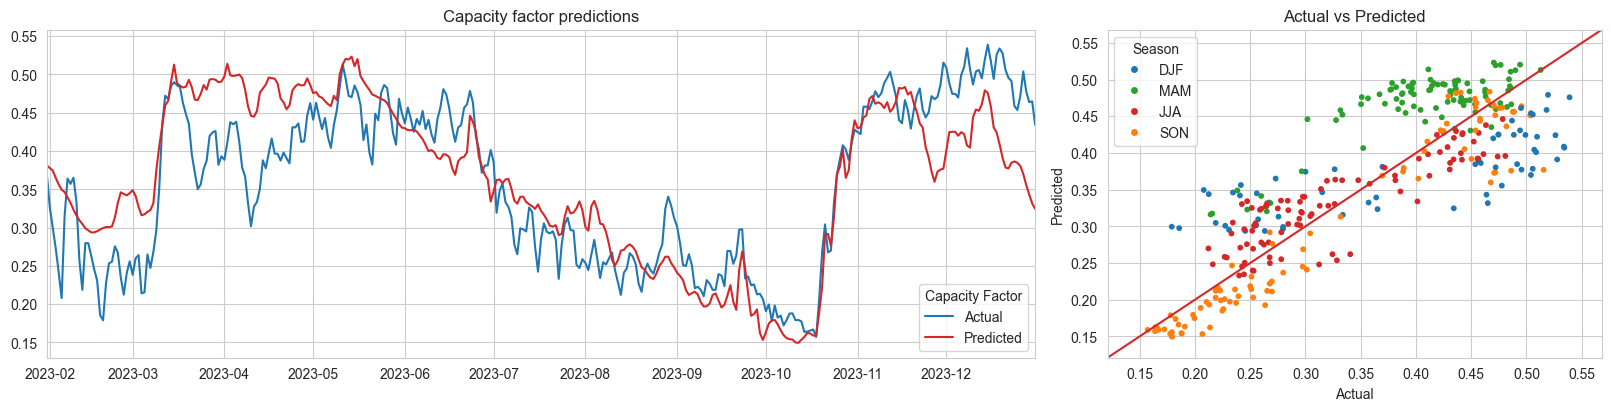

In [24]:
# ==========================================
# 1. Préparation des Données (Tenseurs & Séquences)
# ==========================================

class TimeSeriesDataset(Dataset):
    """
    Classe Dataset personnalisée pour transformer les données tabulaires
    en séquences temporelles adaptées aux LSTM.
    """
    def __init__(self, X, y, sequence_length=30):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length

    def __getitem__(self, i):
        # Entrée : séquence de taille (sequence_length, num_features)
        # Cible : la valeur à t + sequence_length (ou t+1 selon l'horizon souhaité)
        # Ici, on prédit la valeur cible correspondant au pas de temps suivant la séquence
        return self.X[i:i+self.sequence_length], self.y[i+self.sequence_length]

# Paramètres de dimensionnement basés sur votre pré-traitement
# X_train_std contient 4 features : TP_rolling, TA_rolling, Cos_saison, Sin_saison
SEQUENCE_LENGTH = 30  # Fenêtre d'observation (look-back window)
BATCH_SIZE = 64

# Création des Datasets et DataLoaders
# Note : Assurez-vous que les index sont bien alignés (reset_index) avant cette étape
train_dataset = TimeSeriesDataset(X_train_std, y_train, sequence_length=SEQUENCE_LENGTH)
test_dataset = TimeSeriesDataset(X_test_std, y_test, sequence_length=SEQUENCE_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle=False important pour séries temporelles si stateful, mais ici stateless est ok
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 2. Architecture du Modèle LSTM
# ==========================================

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Couche LSTM
        # input_shape attendu : (batch_size, sequence_length, input_size)
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout
        )
        
        # Couche entièrement connectée pour la régression finale
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialisation des états cachés (h_0, c_0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Propagation avant (Forward pass)
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        # On récupère seulement la sortie du dernier pas de temps de la séquence
        # out[:, -1, :] shape: (batch_size, hidden_size)
        out = out[:, -1, :]
        
        # Prédiction finale
        out = self.fc(out)
        return out

# Instanciation du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_std.shape[1] # Devrait être 4 (TP, TA, Cos, Sin)
model = LSTMRegressor(input_size=input_dim, hidden_size=128, num_layers=2, output_size=1).to(device)

# ==========================================
# 3. Boucle d'Entraînement et Optimisation
# ==========================================

criterion = nn.MSELoss() # Fonction de perte pour régression (Mean Squared Error)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
test_losses = []

print("Début de l'entraînement...")

for epoch in range(num_epochs):
    model.train()
    batch_loss = []
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch) # squeeze pour ajuster les dimensions
        
        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
    
    train_epoch_loss = np.mean(batch_loss)
    train_losses.append(train_epoch_loss)
    
    # Évaluation (Validation)
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            v_loss = criterion(outputs.squeeze(), y_val)
            val_loss.append(v_loss.item())
            
    test_epoch_loss = np.mean(val_loss)
    test_losses.append(test_epoch_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Test Loss: {test_epoch_loss:.4f}")

print("Entraînement terminé.")

# ==========================================
# 4. Évaluation et Visualisation Avancée
# ==========================================


model.eval()
all_preds = []

# 1. Inférence (Récupération des prédictions brutes)
with torch.no_grad():
    for X_val, _ in test_loader: # On ignore y_val ici, on utilisera le pandas original
        X_val = X_val.to(device)
        outputs = model(X_val)
        all_preds.extend(outputs.squeeze().cpu().numpy())

y_pred_final = np.array(all_preds)

# 2. Réalignement Temporel (CRITIQUE)
# Le Dataset consomme les 'SEQUENCE_LENGTH' premiers jours pour créer la première fenêtre.
# La première prédiction correspond donc à l'index : start_index + SEQUENCE_LENGTH
# SEQUENCE_LENGTH a été défini à 14 dans le code précédent.

trim_start = SEQUENCE_LENGTH 
# On récupère le sous-ensemble de y_test correspondant aux prédictions
# y_test est la Pandas Series originale issue du train_test_split
y_true_aligned = y_test.iloc[trim_start:]

# Sécurité : Assurer que les longueurs correspondent exactement
# (Le DataLoader peut parfois rejeter le dernier batch incomplet si drop_last=True, 
# bien que shuffle=False et drop_last=False soient par défaut ici)
min_len = min(len(y_true_aligned), len(y_pred_final))
y_true_aligned = y_true_aligned.iloc[:min_len]
y_pred_final = y_pred_final[:min_len]

print(f"Dimensions alignées pour affichage : True {y_true_aligned.shape}, Pred {y_pred_final.shape}")

# 3. Appel de la fonction de visualisation
r2 = r2_score(y_true_aligned, y_pred_final)
mse = mean_squared_error(y_true_aligned, y_pred_final)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()
display_result_season(y_true_aligned, y_pred_final)